# Load LFP

In [2]:
import spikeinterface.full as si
import spikeinterface.widgets as sw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import stft
import pywt
import os

mice = '20250310_VN_tremor'
base_folder = Path(f'/data1/zhangyuhao/xinchao_data/NP2/{mice}')

recording_loaded = si.load(base_folder / 'LFP')
recording_loaded

BinaryFolderRecording: 384 channels - 30000.149167 Hz - 1 segments - 48,401,133 samples 
                       1,613.36s (26.89 minutes) - int16 dtype - 34.62 GiB

In [3]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

traces = recording_loaded.get_traces(segment_index=0)
traces = traces.T
traces

Loaded channels ids: ['imec0.ap#AP0' 'imec0.ap#AP1' 'imec0.ap#AP2' 'imec0.ap#AP3'
 'imec0.ap#AP4' 'imec0.ap#AP5' 'imec0.ap#AP6' 'imec0.ap#AP7'
 'imec0.ap#AP8' 'imec0.ap#AP9' 'imec0.ap#AP10' 'imec0.ap#AP11'
 'imec0.ap#AP12' 'imec0.ap#AP13' 'imec0.ap#AP14' 'imec0.ap#AP15'
 'imec0.ap#AP16' 'imec0.ap#AP17' 'imec0.ap#AP18' 'imec0.ap#AP19'
 'imec0.ap#AP20' 'imec0.ap#AP21' 'imec0.ap#AP22' 'imec0.ap#AP23'
 'imec0.ap#AP24' 'imec0.ap#AP25' 'imec0.ap#AP26' 'imec0.ap#AP27'
 'imec0.ap#AP28' 'imec0.ap#AP29' 'imec0.ap#AP30' 'imec0.ap#AP31'
 'imec0.ap#AP32' 'imec0.ap#AP33' 'imec0.ap#AP34' 'imec0.ap#AP35'
 'imec0.ap#AP36' 'imec0.ap#AP37' 'imec0.ap#AP38' 'imec0.ap#AP39'
 'imec0.ap#AP40' 'imec0.ap#AP41' 'imec0.ap#AP42' 'imec0.ap#AP43'
 'imec0.ap#AP44' 'imec0.ap#AP45' 'imec0.ap#AP46' 'imec0.ap#AP47'
 'imec0.ap#AP48' 'imec0.ap#AP49' 'imec0.ap#AP50' 'imec0.ap#AP51'
 'imec0.ap#AP52' 'imec0.ap#AP53' 'imec0.ap#AP54' 'imec0.ap#AP55'
 'imec0.ap#AP56' 'imec0.ap#AP57' 'imec0.ap#AP58' 'imec0.ap#AP59'
 'imec0.ap#AP6

array([[-7, -4, -5, ...,  3,  3,  3],
       [-2,  1, -1, ...,  1,  1,  1],
       [-2,  2,  1, ...,  2,  2,  2],
       ...,
       [ 6, 29, 26, ...,  4,  4,  4],
       [ 4, 22, 19, ...,  1,  1,  1],
       [ 4, 26, 23, ...,  4,  4,  4]], dtype=int16)

# FFT Block of time

/tmp/ipykernel_1829573/3259143617.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


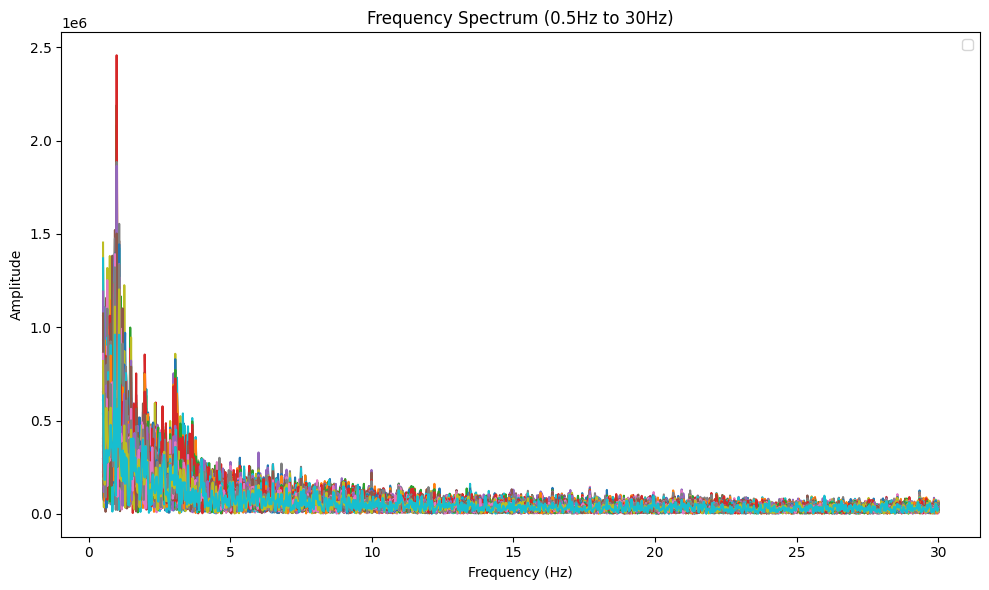

In [ ]:
traces_trunc = traces[:, 10000000:11000000]  # 0-2000000, 2000000-4000000, 4000000-6000000, 6000000-8000000
# Sampling frequency
fs = 30000  # 30 kHz

# Perform FFT for each row
fft_results = np.abs(fft(traces_trunc, axis=1))
frequencies = fftfreq(traces_trunc.shape[1], 1 / fs)

# Filter frequencies between 0.5Hz and 30Hz
freq_mask = (frequencies >= 0.5) & (frequencies <= 30)

# Plot frequency spectrum for all rows in one figure
plt.figure(figsize=(10, 6))
for i in range(traces_trunc.shape[0]):
    plt.plot(frequencies[freq_mask], fft_results[i, freq_mask])
plt.title('Frequency Spectrum (0.5Hz to 30Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

# Load marker

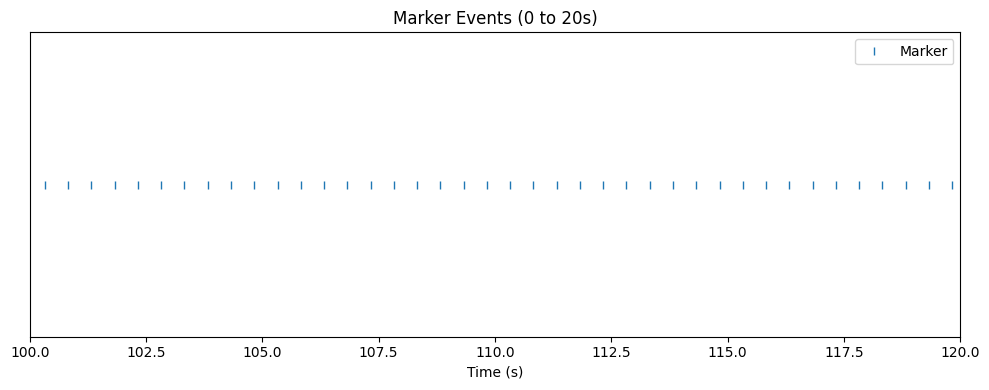

In [13]:
marker = np.load(f'/data1/zhangyuhao/xinchao_data/NP2/{mice}/Marker/run_stop_times_evenRun_odd_Stop.npy')  # unit s
fall_times = np.load(f'/data1/zhangyuhao/xinchao_data/NP2/{mice}/Marker/fall_times.npy')  # unit s
rise_times = np.load(f'/data1/zhangyuhao/xinchao_data/NP2/{mice}/Marker/rise_times.npy')  # unit s
plt.figure(figsize=(10, 4))
plt.plot(marker, np.zeros_like(marker), '|', label='Marker')
plt.xlim(100, 120)
plt.title('Marker Events (0 to 20s)')
plt.xlabel('Time (s)')
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

# Concate locomotion, Concate static

# STFT

Processing 0.0s-60.0s
Processing 60.0s-120.0s


KeyboardInterrupt: 

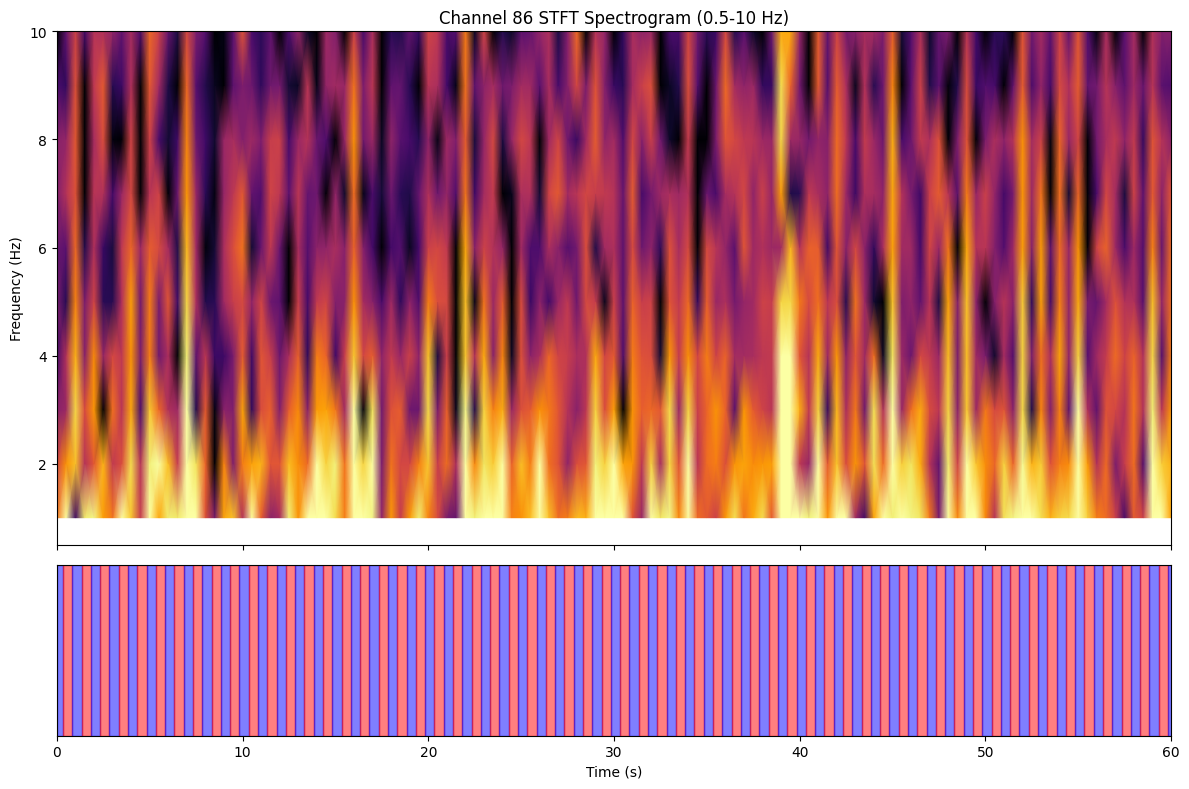

In [9]:
#参数设置
trunc_time = 60 # 60s
fs = 30000  # 采样率
nperseg = 30000  # 2秒窗口  ‌窗口长度
noverlap = 15000  # 50%重叠  相邻窗口之间的重叠样本数
freq_low = 0.5  # 低频截止频率
freq_high = 10  # 高频截止频率
main_path = '/home/zhangyuhao/Desktop/Result/ET/LFP_STFT/'

# Main Program
trunc_points = trunc_time * fs  # 60s is 1800000 sample points
intervals = traces.shape[1] - traces.shape[1] % trunc_points
for start in range(0, intervals, trunc_points):
    end = start + trunc_points
    traces_trunc = traces[:, start:end] # 60s is 1800000 sample points
    start_time = start / fs
    end_time = end / fs
    print(f"Processing {start_time}s-{end_time}s")
    n_channels, n_samples = traces_trunc.shape[0], traces_trunc.shape[1]  # traces的形状
    save_path = main_path + f"{start_time}s-{end_time}s"  # 创建路径
    os.makedirs(save_path, exist_ok=True)

    for channel in range(n_channels):
        signal = traces_trunc[channel]
        # 计算STFT
        freqs, times, Zxx = stft(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
        Zxx_db = 20 * np.log10(np.abs(Zxx) + 1e-8)
        
        # 频率掩码
        freq_mask = (freqs >= freq_low) & (freqs <= freq_high)
        freqs_sub = freqs[freq_mask]
        Zxx_sub = Zxx_db[freq_mask, :]

        # 创建画布和子图
        fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, 
                                    figsize=(12, 8), sharex=True)
        
        # 绘制频谱图
        im = ax1.pcolormesh(times, freqs_sub, Zxx_sub, shading='gouraud', cmap='inferno',
                            vmin=np.percentile(Zxx_sub, 5), vmax=np.percentile(Zxx_sub, 95))
        #fig.colorbar(im, ax=ax1, pad=0.02, label='Magnitude (dB)')
        ax1.set_ylim(freq_low, freq_high)
        ax1.set_ylabel('Frequency (Hz)')
        ax1.set_title(f'Channel {channel+1} STFT Spectrogram ({freq_low}-{freq_high} Hz)')

        # 处理事件时间区间
        event_mask = (marker > start_time) & (marker < end_time)
        event_indices = np.where(event_mask)[0]
        event_times = marker[event_mask] - start_time  # 转换为相对时间

        if len(event_indices) > 0:
            # 确定颜色交替顺序
            first_index = event_indices[0]
            first_co = 'red' if first_index % 2 == 1 else 'blue'
            second_co = 'blue' if first_co == 'red' else 'red'

            # 排序事件时间并添加边界
            sorted_events = np.sort(event_times)
            boundaries = np.concatenate([[0], sorted_events, [times[-1]]])

            # 绘制交替颜色区间
            for i in range(len(boundaries) - 1):
                color = first_co if i % 2 == 0 else second_co
                ax2.axvspan(boundaries[i], boundaries[i+1], color=color, alpha=0.5)

        # 设置下方子图属性
        ax2.set_yticks([])
        ax2.set_xlabel('Time (s)')

        # 调整布局并保存
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, f'channel_{channel}_STFT.png'), dpi=150)
        plt.close()

print("全部处理完成！")